### Perguntas a serem respondidas
---


1. Feature mais importante

2. Justificativa técnica

3. Interpretação de negócio

4. Ação sugerida

#### Configurações para importar dados

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Conectar ao banco de dados SQLite
conn = sqlite3.connect(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\seguros.db')

df_dict = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\backend\data\raw\P18_dicionario_dados.csv', encoding='utf-8', sep=',')
df_cancel = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\backend\data\raw\P18_cancelamentos.csv', encoding='utf-8', sep=',')
df_contratos = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\backend\data\raw\P18_contratos.csv', encoding='utf-8', sep=',')
df_clientes= pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\backend\data\raw\P18_clientes.csv', encoding='utf-8', sep=',')
df_clientes.to_sql('clientes', conn, if_exists='replace', index=False)
df_contratos.to_sql('contratos', conn, if_exists='replace', index=False)
df_cancel.to_sql('cancelamentos', conn, if_exists='replace', index=False)

# Carregar as tabelas como DataFrames do pandas
df_clientes = pd.read_sql_query("SELECT * FROM clientes", conn)
df_contratos = pd.read_sql_query("SELECT * FROM contratos", conn)
df_cancel = pd.read_sql_query("SELECT * FROM cancelamentos", conn)



### Query do Modelo

In [5]:
query = """ 
SELECT
  substr(c.id_cliente, 2) AS id_cliente,
  cl.genero,
  cl.data_nascimento,
  CAST(strftime('%Y', 'now') AS INTEGER) - CAST(strftime('%Y', cl.data_nascimento) AS INTEGER) AS idade,
  cl.renda_mensal,
  cl.nivel_educacional,
  cl.qtd_dependentes,
  c.tipo_seguro,
  c.valor_premio_mensal,
  c.satisfacao_ultima_avaliacao,
  c.canal_venda,
  c.renovado_automaticamente,
  ca.motivo_cancelamento,
  DATE(c.data_inicio) AS inicio,
  DATE(c.data_fim) AS fim,
  julianday(c.data_fim) - julianday(c.data_inicio) AS duracao_dias,

  CASE 
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) <= 31 THEN 'Mensal'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 32 AND 92 THEN 'Trimestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 93 AND 183 THEN 'Semestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 184 AND 366 THEN 'Anual'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) > 366 THEN 'Bianual'
    ELSE 'Indefinido'
  END AS tipo_duracao,

  CASE 
    WHEN ca.id_contrato IS NOT NULL THEN 1
    ELSE 0
  END AS cancelado

FROM contratos c
JOIN clientes cl ON c.id_cliente = cl.id_cliente
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato

-- ✅ Mantém apenas contratos ativos ou cancelados
WHERE ca.id_contrato IS NOT NULL
   OR DATE('now') BETWEEN DATE(c.data_inicio) AND DATE(c.data_fim)
;

"""
df = pd.read_sql_query(query, conn)
df['id_cliente'] = df['id_cliente'].astype(int)
df = df.drop('data_nascimento', axis=1)
df = df.drop('id_cliente', axis=1)
df = df.drop('motivo_cancelamento', axis=1)
df = df.drop('inicio', axis=1)
df = df.drop('fim', axis=1)
df = df.drop('duracao_dias', axis=1)


df


,genero,idade,renda_mensal,nivel_educacional,qtd_dependentes,tipo_seguro,valor_premio_mensal,satisfacao_ultima_avaliacao,canal_venda,renovado_automaticamente,tipo_duracao,cancelado
0,Outro,66,12406.88,Técnico,2,Empresarial,892.30,Média,Site,0,Semestral,1
1,Outro,67,18950.78,Superior,3,Vida,962.07,Baixa,Agência Física,0,Bianual,0
2,Feminino,46,17135.37,Técnico,3,Vida,996.09,Baixa,App,1,Semestral,1
3,Masculino,77,13945.07,Pós,2,Saúde,1158.48,Baixa,Site,1,Bianual,0
4,Masculino,19,11315.19,Superior,0,Vida,840.08,Média,Site,1,Anual,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6093,Masculino,19,15801.76,Fundamental,0,Vida,599.48,Alta,Agência Física,1,Bianual,1
6094,Masculino,57,3167.47,Superior,1,Residencial,334.17,Baixa,Agência Física,0,Semestral,1
6095,Outro,45,1655.74,Médio,1,Vida,897.26,Alta,Site,0,Bianual,0
6096,Outro,45,16652.42,Médio,0,Vida,1478.74,Alta,Agência Física,0,Bianual,1


### Modelo

Essa análise foi para identificar que nem todas as colunas categóricas estavam sendo utilizadas como fator, e o motivo foi porque estava codificado para que o ONeHotEncoder dropasse a primeira coluna.
> a solução foi trocar de drop=First para drop None

> Mais alguns testes para ter sobre o modelo, para termos um desempenho melhor
Remover essas 5 features e reavaliar

Criar novas features derivadas com base nessas

Comparar o desempenho do modelo antes/depois

#### Criando novas Features a partir das com baixo desempenho
- renda_mensal
- qtd_dependentes
- nivel_educacional_Médio
- tipo_seguro_Empresarial
- tipo_seguro_Saúde

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define variáveis categóricas
categorical_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"
]

# 3. Divide treino/teste
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None, sparse_output=False), categorical_features),
        ("num", StandardScaler(), list(set(X.columns) - set(categorical_features)))
    ]
)

# 5. Pipeline completa com modelo
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight='balanced', max_iter=1000))
])

# 6. Aplica pré-processamento manual para SMOTE
X_train_encoded = preprocessor.fit_transform(X_train_raw)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)

# 7. Treina o modelo com os dados balanceados
pipeline.named_steps['model'].fit(X_resampled, y_resampled)

# 8. Previsão
X_test_encoded = preprocessor.transform(X_test_raw)
y_pred = pipeline.named_steps['model'].predict(X_test_encoded)

# 9. Avaliação
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# 10. Interpretando os coeficientes
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
numerical_features = list(set(X.columns) - set(categorical_features))
all_features = feature_names + numerical_features

coeffs = pipeline.named_steps['model'].coef_[0]
coef_df = pd.DataFrame({
    'feature': all_features,
    'coef': coeffs
}).sort_values(by="coef", ascending=False)

print("💡 Principais Features que Aumentam o Churn:")
print(coef_df.head(10))

print("\n💡 Principais Features que Reduzem o Churn:")
print(coef_df.tail(10))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       713
           1       0.55      0.62      0.58       516

    accuracy                           0.63      1229
   macro avg       0.63      0.63      0.63      1229
weighted avg       0.64      0.63      0.63      1229

📉 Matriz de Confusão:
[[457 256]
 [197 319]]
💡 Principais Features que Aumentam o Churn:
                              feature      coef
22             tipo_duracao_Semestral  0.869330
11                  tipo_seguro_Saúde  0.132341
10            tipo_seguro_Residencial  0.102506
5               nivel_educacional_Pós  0.100506
6          nivel_educacional_Superior  0.097421
17                    canal_venda_App  0.087484
14  satisfacao_ultima_avaliacao_Baixa  0.078902
18               canal_venda_Corretor  0.072394
9             tipo_seguro_Empresarial  0.046531
1                    genero_Masculino  0.040229

💡 Principais Features que Redu

## 1. Avaliar a necessidade de balanceamento com SMOTE
---

- Analisar o desequilíbrio da variável target (cancelado):

- 2520 cancelados vs. 3660 ativos → classe 1 = 41% → o desequilíbrio existe, mas não é extremo.

- SMOTE pode ser útil, mas teste com e sem:

- Compare o recall, precision, e a matriz de confusão.

- Use stratified k-fold para avaliar a estabilidade dos resultados.

## 2. Refatorar e criar novas features (feature engineering)
---



**Ajustes em features existentes:**

- idade → converter em faixa_etaria (ex: 18-30, 31-45, etc.)

- satisfacao_ultima_avaliacao → converter para score numérico (ex: Baixa = 0, Média = 1, Alta = 2)

***Agrupamentos e interações úteis:**

- renda_por_dependente = renda_mensal / (1 + qtd_dependentes)

- valor_premio_sobre_renda = valor_premio_mensal / renda_mensal

- interacao_idade_renda = idade * renda_mensal (se fizer sentido no seu contexto)

***Indicadores binários inteligentes:**

- faixa_renda_baixa_premio_alto = 1 se valor_premio_sobre_renda > 0.3

- tem_dependentes_e_seguro_vida = 1 se qtd_dependentes > 0 and tipo_seguro == 'Vida'

***Seguros de alto risco (nova variável):**

- Criar feature binária: seguro_alto_risco = 1 se churn_rate_tipo_seguro > 21%


In [6]:
query = """ 
SELECT
  substr(c.id_cliente, 2) AS id_cliente,
  cl.genero,
  cl.data_nascimento,
  CAST(strftime('%Y', 'now') AS INTEGER) - CAST(strftime('%Y', cl.data_nascimento) AS INTEGER) AS idade,
  cl.renda_mensal,
  cl.nivel_educacional,
  cl.qtd_dependentes,
  c.tipo_seguro,
  c.valor_premio_mensal,
  c.satisfacao_ultima_avaliacao,
  c.canal_venda,
  c.renovado_automaticamente,
  ca.motivo_cancelamento,
  DATE(c.data_inicio) AS inicio,
  DATE(c.data_fim) AS fim,
  julianday(c.data_fim) - julianday(c.data_inicio) AS duracao_dias,

  CASE 
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) <= 31 THEN 'Mensal'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 32 AND 92 THEN 'Trimestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 93 AND 183 THEN 'Semestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 184 AND 366 THEN 'Anual'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) > 366 THEN 'Bianual'
    ELSE 'Indefinido'
  END AS tipo_duracao,

  CASE 
    WHEN ca.id_contrato IS NOT NULL THEN 1
    ELSE 0
  END AS cancelado

FROM contratos c
JOIN clientes cl ON c.id_cliente = cl.id_cliente
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato

-- ✅ Mantém apenas contratos ativos ou cancelados
WHERE ca.id_contrato IS NOT NULL
   OR DATE('now') BETWEEN DATE(c.data_inicio) AND DATE(c.data_fim)
;

"""
df = pd.read_sql_query(query, conn)
df['id_cliente'] = df['id_cliente'].astype(int)
df = df.drop('data_nascimento', axis=1)
df = df.drop('id_cliente', axis=1)
df = df.drop('motivo_cancelamento', axis=1)
df = df.drop('inicio', axis=1)
df = df.drop('fim', axis=1)


df


,genero,idade,renda_mensal,nivel_educacional,qtd_dependentes,tipo_seguro,valor_premio_mensal,satisfacao_ultima_avaliacao,canal_venda,renovado_automaticamente,duracao_dias,tipo_duracao,cancelado
0,Outro,66,12406.88,Técnico,2,Empresarial,892.30,Média,Site,0,180.0,Semestral,1
1,Outro,67,18950.78,Superior,3,Vida,962.07,Baixa,Agência Física,0,730.0,Bianual,0
2,Feminino,46,17135.37,Técnico,3,Vida,996.09,Baixa,App,1,180.0,Semestral,1
3,Masculino,77,13945.07,Pós,2,Saúde,1158.48,Baixa,Site,1,730.0,Bianual,0
4,Masculino,19,11315.19,Superior,0,Vida,840.08,Média,Site,1,365.0,Anual,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,Masculino,19,15801.76,Fundamental,0,Vida,599.48,Alta,Agência Física,1,730.0,Bianual,1
6094,Masculino,57,3167.47,Superior,1,Residencial,334.17,Baixa,Agência Física,0,180.0,Semestral,1
6095,Outro,45,1655.74,Médio,1,Vida,897.26,Alta,Site,0,730.0,Bianual,0
6096,Outro,45,16652.42,Médio,0,Vida,1478.74,Alta,Agência Física,0,730.0,Bianual,1


genero	
idade
renda_mensal	
nivel_educacional - Categorico	5
qtd_dependentes	
tipo_seguro - Categorico	6
valor_premio_mensal	
satisfacao_ultima_avaliacao - Categorico 3	
canal_venda - Categorico	4
renovado_automaticamente	
tipo_duracao - Categorico 	3
cancelado - Target

Criando as novas features

,genero,nivel_educacional,canal_venda,renovado_automaticamente,duracao_dias,cancelado,faixa_etaria,satisfacao_score,renda_por_dependente,valor_premio_sobre_renda,interacao_idade_renda,faixa_renda_baixa_premio_alto,tem_dependentes_e_seguro_vida,seguro_alto_risco
0,Outro,Técnico,Site,0,180.0,1,61-75,1,4135.626667,0.071920,818854.08,0,0,1
1,Outro,Superior,Agência Física,0,730.0,0,61-75,0,4737.695000,0.050767,1269702.26,0,1,1
2,Feminino,Técnico,App,1,180.0,1,46-60,0,4283.842500,0.058131,788227.02,0,1,1
3,Masculino,Pós,Site,1,730.0,0,76+,0,4648.356667,0.083075,1073770.39,0,0,1
4,Masculino,Superior,Site,1,365.0,1,18-30,1,11315.190000,0.074244,214988.61,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,Masculino,Fundamental,Agência Física,1,730.0,1,18-30,2,15801.760000,0.037938,300233.44,0,0,1
6140,Masculino,Superior,Agência Física,0,180.0,1,46-60,0,1583.735000,0.105501,180545.79,0,0,1
6141,Outro,Médio,Site,0,730.0,0,31-45,2,827.870000,0.541909,74508.30,1,1,1
6142,Outro,Médio,Agência Física,0,730.0,1,31-45,2,16652.420000,0.088800,749358.90,0,0,1


##  3. Testar modelos e comparações

#### 3.1 LogisticRegression (já interpretável) 


SEM SMOTE E FEATURES ORIGINAIS

#### 3.2 RandomForestClassifier (robusto e bom para baseline)


#### Conclusões
----
COM SMOTE e as features originais, o desempenho foi melhor.

SEM SMOTE E FEATURES ORIGINAIS

COM SMOTE E FEATURES ORIGINAIS

In [ ]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica o SMOTE para balancear a base
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70       704
           1       0.74      0.59      0.65       744

    accuracy                           0.68      1448
   macro avg       0.69      0.68      0.68      1448
weighted avg       0.69      0.68      0.68      1448

[[548 156]
 [306 438]]


#### 3.3 CatBoostClassifier

SEM SMOTE E FEATURES ORIGINAIS

COM SMOTE E FEATURES ORIGINAIS

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72       704
           1       0.75      0.59      0.66       744

    accuracy                           0.69      1448
   macro avg       0.70      0.69      0.69      1448
weighted avg       0.70      0.69      0.69      1448

[[560 144]
 [302 442]]


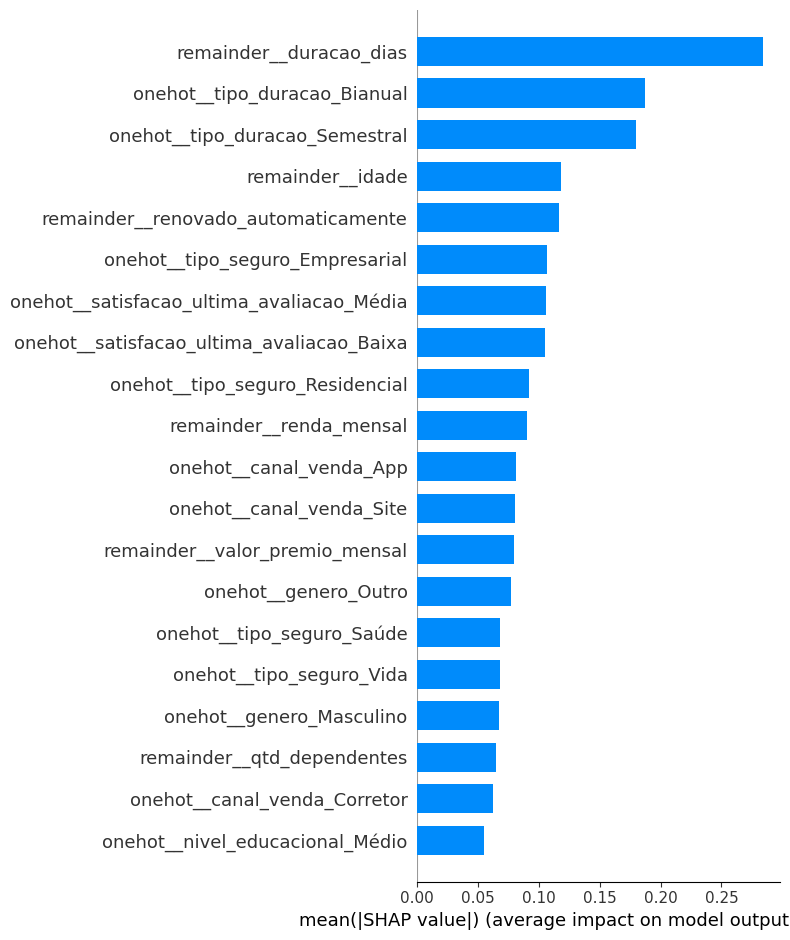


📝 Top 10 features que MAIS impactam a previsão:
                                  feature  importance
                  remainder__duracao_dias    0.283968
             onehot__tipo_duracao_Bianual    0.187376
           onehot__tipo_duracao_Semestral    0.180167
                         remainder__idade    0.117949
      remainder__renovado_automaticamente    0.116097
          onehot__tipo_seguro_Empresarial    0.106414
onehot__satisfacao_ultima_avaliacao_Média    0.105643
onehot__satisfacao_ultima_avaliacao_Baixa    0.105355
          onehot__tipo_seguro_Residencial    0.091798
                  remainder__renda_mensal    0.089976

📝 Top 10 features que MENOS impactam a previsão:
                           feature  importance
              onehot__genero_Outro    0.076648
         onehot__tipo_seguro_Saúde    0.068229
          onehot__tipo_seguro_Vida    0.068102
          onehot__genero_Masculino    0.067107
        remainder__qtd_dependentes    0.064748
      onehot__canal_venda

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica o SMOTE para balancear a base
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = CatBoostClassifier(
    random_state=42,
    verbose=0,  # silencia o output do CatBoost
    eval_metric='F1'
)

model.fit(X_train, y_train)


# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)

explainer = shap.TreeExplainer(model)

# Converte para array denso se for esparso
if hasattr(X_test, "toarray"):
    X_test_dense = X_test.toarray()
else:
    X_test_dense = X_test

shap_values = explainer.shap_values(X_test_dense)

shap.summary_plot(
    shap_values,
    X_test_dense,
    feature_names=encoder.get_feature_names_out(),
    plot_type="bar"
)# 1. Calcula importância média absoluta dos valores SHAP por feature
shap_importance = np.abs(shap_values).mean(axis=0)

# 2. Pega nomes das features
feature_names = encoder.get_feature_names_out()

# 3. Cria DataFrame para facilitar visualização
df_shap_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_importance
})

# 4. Ordena do mais importante para o menos importante
df_shap_imp_sorted = df_shap_imp.sort_values(by='importance', ascending=False)

print("\n📝 Top 10 features que MAIS impactam a previsão:")
print(df_shap_imp_sorted.head(10).to_string(index=False))

print("\n📝 Top 10 features que MENOS impactam a previsão:")
print(df_shap_imp_sorted.tail(10).to_string(index=False))




COM SMOTE E FEATURES ORIGINAIS

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "canal_venda","faixa_etaria"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = CatBoostClassifier(
    random_state=42,
    verbose=0,  # silencia o output do CatBoost
    eval_metric='F1'
)

model.fit(X_train, y_train)


# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)




ValueError: A given column is not a column of the dataframe

# AAAAAAAAAAAAAAAAAAAAAAA


COM DF

In [7]:
df_att = df.copy()

bins = [17, 30, 45, 60, 75, 100]
labels = ['18-30', '31-45', '46-60', '61-75', '76+']
df_att['faixa_etaria'] = pd.cut(df_att['idade'], bins=bins, labels=labels)

mapa_satisfacao = {'Baixa': 0, 'Média': 1, 'Alta': 2}
df_att['satisfacao_score'] = df_att['satisfacao_ultima_avaliacao'].map(mapa_satisfacao)

df_att['renda_por_dependente'] = df_att['renda_mensal'] / (df_att['qtd_dependentes'] + 1)

df_att['valor_premio_sobre_renda'] = df_att['valor_premio_mensal'] / df_att['renda_mensal']
df_att['interacao_idade_renda'] = df_att['idade'] * df_att['renda_mensal']
df_att['faixa_renda_baixa_premio_alto'] = (df_att['valor_premio_sobre_renda'] > 0.3).astype(int)
df_att['tem_dependentes_e_seguro_vida'] = ((df_att['qtd_dependentes'] > 0) & (df_att['tipo_seguro'] == 'Vida')).astype(int)

churn_por_tipo = df_att.groupby('tipo_seguro')['cancelado'].mean()

# Marcar quais são de alto risco (churn > 21%)
tipos_alto_risco = churn_por_tipo[churn_por_tipo > 0.21].index.tolist()

# Criar nova coluna
df_att['seguro_alto_risco'] = df_att['tipo_seguro'].isin(tipos_alto_risco).astype(int)

df_att.drop('satisfacao_ultima_avaliacao', axis=1, inplace=True)
df_att.drop('idade', axis=1, inplace=True)
df_att.drop('qtd_dependentes', axis=1, inplace=True)
df_att.drop('renda_mensal', axis=1, inplace=True)
df_att.drop('tipo_seguro', axis=1, inplace=True)
df_att.drop('tipo_duracao', axis=1, inplace=True)

df_att

,genero,nivel_educacional,valor_premio_mensal,canal_venda,renovado_automaticamente,duracao_dias,cancelado,faixa_etaria,satisfacao_score,renda_por_dependente,valor_premio_sobre_renda,interacao_idade_renda,faixa_renda_baixa_premio_alto,tem_dependentes_e_seguro_vida,seguro_alto_risco
0,Outro,Técnico,892.30,Site,0,180.0,1,61-75,1,4135.626667,0.071920,818854.08,0,0,1
1,Outro,Superior,962.07,Agência Física,0,730.0,0,61-75,0,4737.695000,0.050767,1269702.26,0,1,1
2,Feminino,Técnico,996.09,App,1,180.0,1,46-60,0,4283.842500,0.058131,788227.02,0,1,1
3,Masculino,Pós,1158.48,Site,1,730.0,0,76+,0,4648.356667,0.083075,1073770.39,0,0,1
4,Masculino,Superior,840.08,Site,1,365.0,1,18-30,1,11315.190000,0.074244,214988.61,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,Masculino,Fundamental,599.48,Agência Física,1,730.0,1,18-30,2,15801.760000,0.037938,300233.44,0,0,1
6094,Masculino,Superior,334.17,Agência Física,0,180.0,1,46-60,0,1583.735000,0.105501,180545.79,0,0,1
6095,Outro,Médio,897.26,Site,0,730.0,0,31-45,2,827.870000,0.541909,74508.30,1,1,1
6096,Outro,Médio,1478.74,Agência Física,0,730.0,1,31-45,2,16652.420000,0.088800,749358.90,0,0,1


#### LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, KNeighborsClassifier, SVC, CatBoostClassifier, XGBClassifier, LGBMClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 1. Define os dados
X = df_att.drop("cancelado", axis=1)
y = df_att["cancelado"]

categorical_features = ["genero", "nivel_educacional", "canal_venda","faixa_etaria"]

encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 2. Divide treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 3. Lista de modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# 4. Avaliação
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

# 5. Resultados ordenados por F1
df_resultados = pd.DataFrame(results)
df_resultados = df_resultados.sort_values(by="F1-score", ascending=False).reset_index(drop=True)

print("🔎 Comparativo de Modelos:")
print(df_resultados)


[LightGBM] [Info] Number of positive: 2000, number of negative: 2911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 4911, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.407249 -> initscore=-0.375349
[LightGBM] [Info] Start training from score -0.375349
🔎 Comparativo de Modelos:
                Modelo  Accuracy  Precision    Recall  F1-score   ROC AUC
0  Logistic Regression  0.655537   0.614118  0.501923  0.552381  0.679846
1             CatBoost  0.646580   0.623563  0.417308  0.500000  0.664689
2             LightGBM  0.631922   0.592391  0.419231  0.490991  0.662932
3    Gradient Boosting  0.647394   0.634675  0.394231  0.486358  0.678403
4              XGBoost  0.606678   0.544578  0.434

#### LOGISTIC REGRESSION

#### RANDOMFOREST

#### CATBOOTST

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       704
           1       0.76      0.61      0.67       744

    accuracy                           0.70      1448
   macro avg       0.71      0.70      0.70      1448
weighted avg       0.71      0.70      0.69      1448

📉 Confusion Matrix:
[[558 146]
 [293 451]]
🔎 Métricas:
Accuracy: 0.6968232044198895
Precision: 0.7554438860971524
Recall: 0.6061827956989247
F1-score: 0.6726323639075317
ROC AUC: 0.7541009897360703


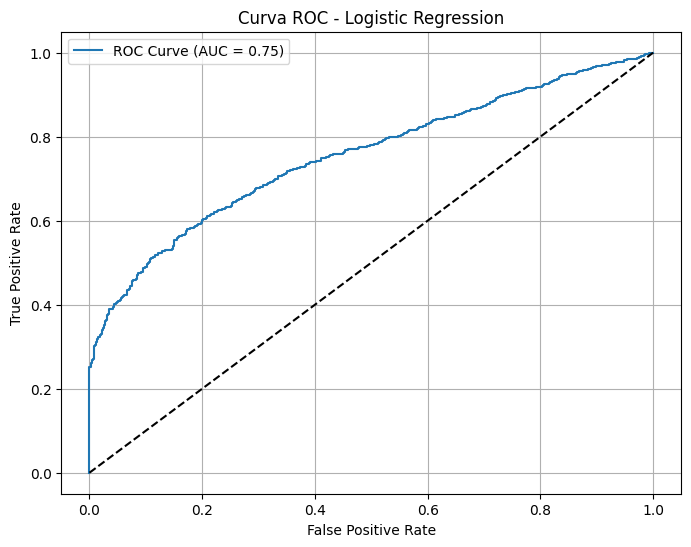

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df_att.drop("cancelado", axis=1)
y = df_att["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "canal_venda","faixa_etaria"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = CatBoostClassifier(
    random_state=42,
    verbose=0,  # silencia o output do CatBoost
    eval_metric='F1'
)

model.fit(X_train, y_train)


# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1]

print("🔎 Métricas:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 7. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()



### APLICANDO SHAP PARA IDENTIFICAR QUAIS FEATURES TIVERAM IMPACTO

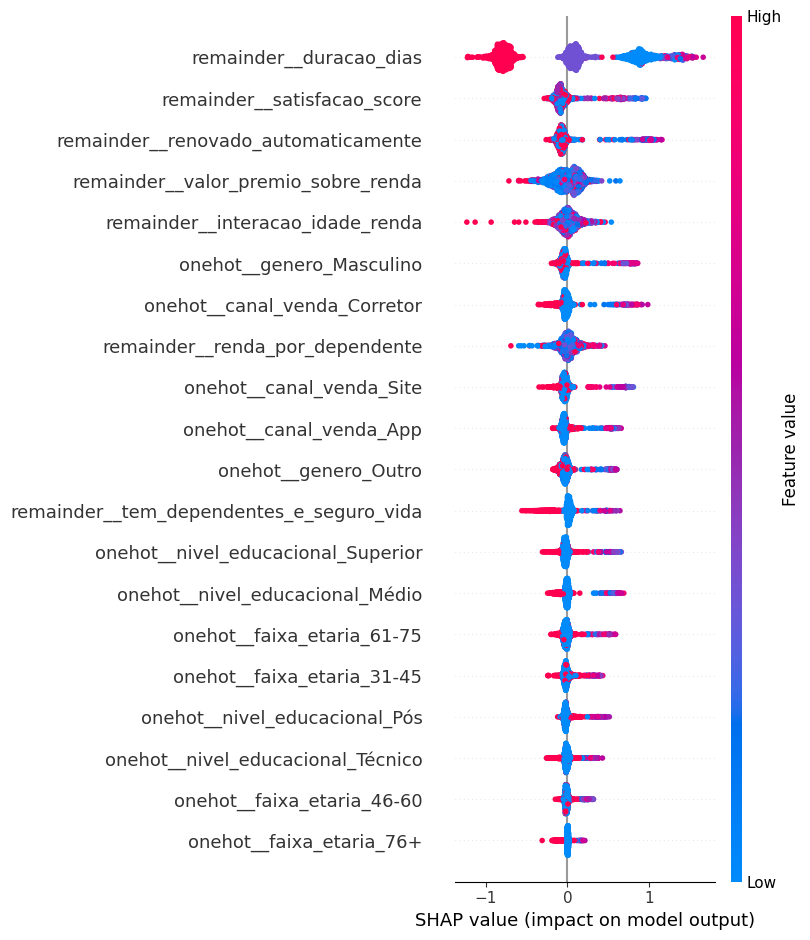

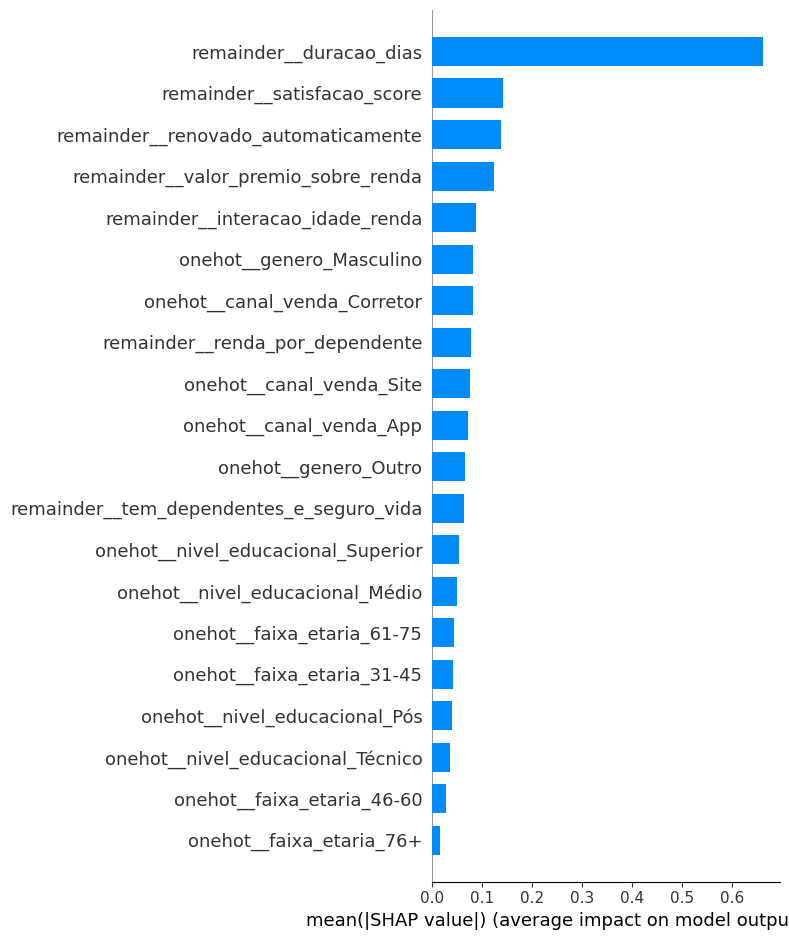

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# --- Seu código original até treino ---

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df_att.drop("cancelado", axis=1)
y = df_att["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "canal_venda","faixa_etaria"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina CatBoost
model = CatBoostClassifier(
    random_state=42,
    verbose=0,
    eval_metric='F1'
)
model.fit(X_train, y_train)

# 6. Avaliação
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# --- SHAP ---

# 7. Explicação SHAP
explainer = shap.TreeExplainer(model)

# Se X_test for esparso, converte para denso
if hasattr(X_test, "toarray"):
    X_test_dense = X_test.toarray()
else:
    X_test_dense = X_test

shap_values = explainer.shap_values(X_test_dense)

# 8. Summary plot (importância global das features)
shap.summary_plot(shap_values, X_test_dense, feature_names=encoder.get_feature_names_out())
shap.summary_plot(shap_values, X_test_dense, feature_names=encoder.get_feature_names_out(), plot_type="bar")

# 9. Force plot (explicação individual) para o primeiro cliente de teste
shap.force_plot(explainer.expected_value, shap_values[0], X_test_dense[0], feature_names=encoder.get_feature_names_out())


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       704
           1       0.76      0.61      0.67       744

    accuracy                           0.70      1448
   macro avg       0.71      0.70      0.70      1448
weighted avg       0.71      0.70      0.69      1448

📉 Confusion Matrix:
[[558 146]
 [293 451]]
🔎 Métricas:
Accuracy: 0.6968
Precision: 0.7554
Recall: 0.6062
F1-score: 0.6726
ROC AUC: 0.7541


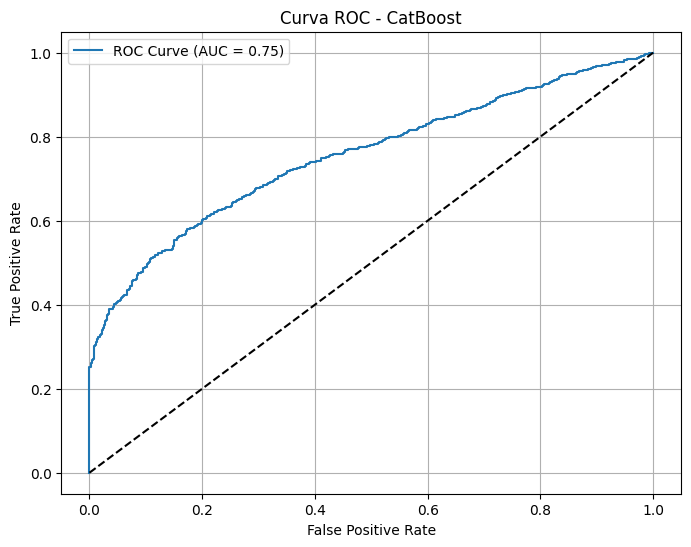

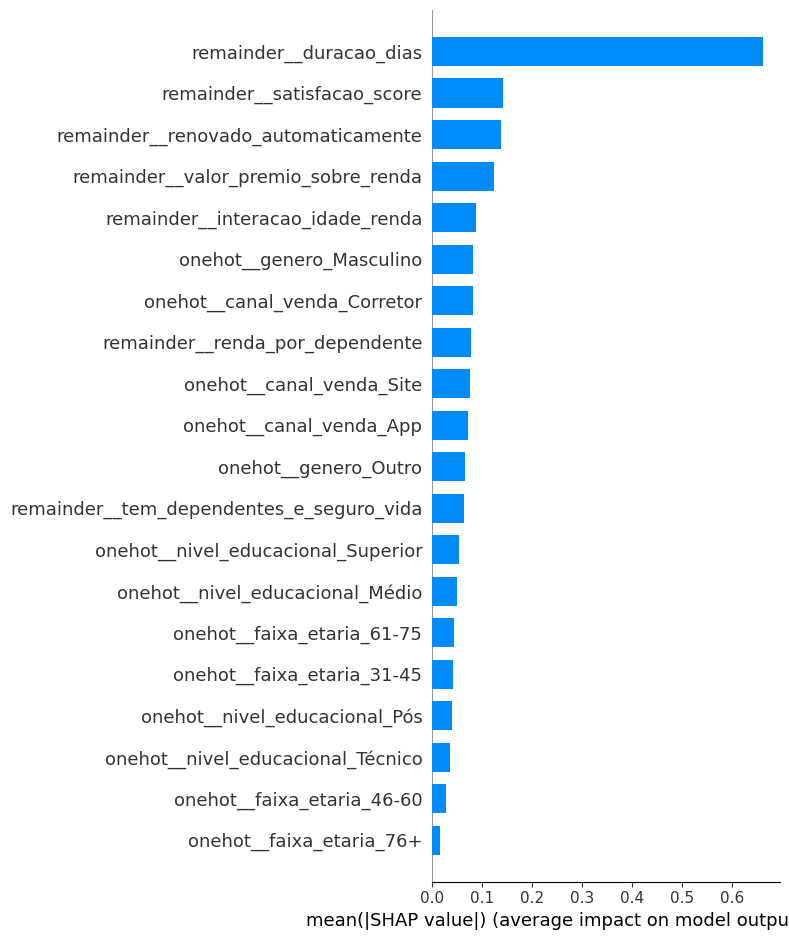


📝 Top 10 features que MAIS impactam a previsão:
                            feature  importance
            remainder__duracao_dias    0.661916
        remainder__satisfacao_score    0.141701
remainder__renovado_automaticamente    0.137210
remainder__valor_premio_sobre_renda    0.123175
   remainder__interacao_idade_renda    0.087893
           onehot__genero_Masculino    0.082698
       onehot__canal_venda_Corretor    0.081286
    remainder__renda_por_dependente    0.078617
           onehot__canal_venda_Site    0.076552
            onehot__canal_venda_App    0.072256

📝 Top 10 features que MENOS impactam a previsão:
                                 feature  importance
      onehot__nivel_educacional_Superior    0.053306
         onehot__nivel_educacional_Médio    0.049593
              onehot__faixa_etaria_61-75    0.042827
              onehot__faixa_etaria_31-45    0.042249
           onehot__nivel_educacional_Pós    0.039115
       onehot__nivel_educacional_Técnico    0.035363
  

In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# 1. Dados
X = df_att.drop("cancelado", axis=1)
y = df_att["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "canal_venda", "faixa_etaria"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X)

# 3. Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 5. Treina CatBoost
model = CatBoostClassifier(random_state=42, verbose=0, eval_metric='F1')
model.fit(X_train, y_train)

# 6. Avaliação
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔎 Métricas:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - CatBoost")
plt.legend()
plt.grid()
plt.show()

# 7. SHAP - Explicação com gráfico de barras
explainer = shap.TreeExplainer(model)

# Converte para array denso se for esparso
if hasattr(X_test, "toarray"):
    X_test_dense = X_test.toarray()
else:
    X_test_dense = X_test

shap_values = explainer.shap_values(X_test_dense)

shap.summary_plot(
    shap_values,
    X_test_dense,
    feature_names=encoder.get_feature_names_out(),
    plot_type="bar"
)# 1. Calcula importância média absoluta dos valores SHAP por feature
shap_importance = np.abs(shap_values).mean(axis=0)

# 2. Pega nomes das features
feature_names = encoder.get_feature_names_out()

# 3. Cria DataFrame para facilitar visualização
df_shap_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_importance
})

# 4. Ordena do mais importante para o menos importante
df_shap_imp_sorted = df_shap_imp.sort_values(by='importance', ascending=False)

print("\n📝 Top 10 features que MAIS impactam a previsão:")
print(df_shap_imp_sorted.head(10).to_string(index=False))

print("\n📝 Top 10 features que MENOS impactam a previsão:")
print(df_shap_imp_sorted.tail(10).to_string(index=False))


## Novas Features

In [9]:
df_att_2 = df.copy()

mapa_satisfacao = {'Baixa': 0, 'Média': 1, 'Alta': 2}
df_att_2['satisfacao_score'] = df_att_2['satisfacao_ultima_avaliacao'].map(mapa_satisfacao)


df_att_2['valor_premio_sobre_renda'] = df_att_2['valor_premio_mensal'] / df_att_2['renda_mensal']
df_att_2['interacao_idade_renda'] = df_att_2['idade'] * df_att_2['renda_mensal']

df_att_2.drop('satisfacao_ultima_avaliacao', axis=1, inplace=True)
df_att_2.drop('qtd_dependentes', axis=1, inplace=True)
df_att_2.drop('renda_mensal', axis=1, inplace=True)
df_att_2.drop('tipo_duracao', axis=1, inplace=True)
df_att_2.drop('genero', axis=1, inplace=True)
df_att_2.drop('nivel_educacional', axis=1, inplace=True)
df_att_2.drop('canal_venda', axis=1, inplace=True)

df_att_2

,idade,tipo_seguro,valor_premio_mensal,renovado_automaticamente,duracao_dias,cancelado,satisfacao_score,valor_premio_sobre_renda,interacao_idade_renda
0,66,Empresarial,892.30,0,180.0,1,1,0.071920,818854.08
1,67,Vida,962.07,0,730.0,0,0,0.050767,1269702.26
2,46,Vida,996.09,1,180.0,1,0,0.058131,788227.02
3,77,Saúde,1158.48,1,730.0,0,0,0.083075,1073770.39
4,19,Vida,840.08,1,365.0,1,1,0.074244,214988.61
...,...,...,...,...,...,...,...,...,...
6093,19,Vida,599.48,1,730.0,1,2,0.037938,300233.44
6094,57,Residencial,334.17,0,180.0,1,0,0.105501,180545.79
6095,45,Vida,897.26,0,730.0,0,2,0.541909,74508.30
6096,45,Vida,1478.74,0,730.0,1,2,0.088800,749358.90


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       704
           1       0.75      0.61      0.67       744

    accuracy                           0.69      1448
   macro avg       0.70      0.70      0.69      1448
weighted avg       0.70      0.69      0.69      1448

📉 Confusion Matrix:
[[550 154]
 [288 456]]
🔎 Métricas:
Accuracy: 0.6948
Precision: 0.7475
Recall: 0.6129
F1-score: 0.6736
ROC AUC: 0.7513


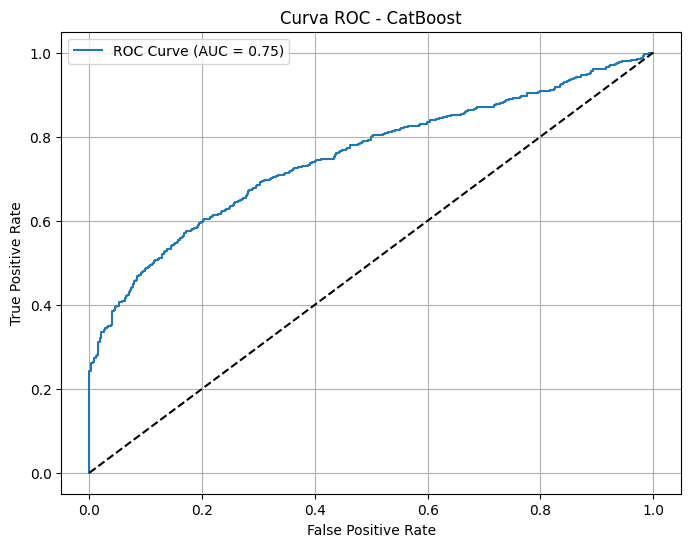

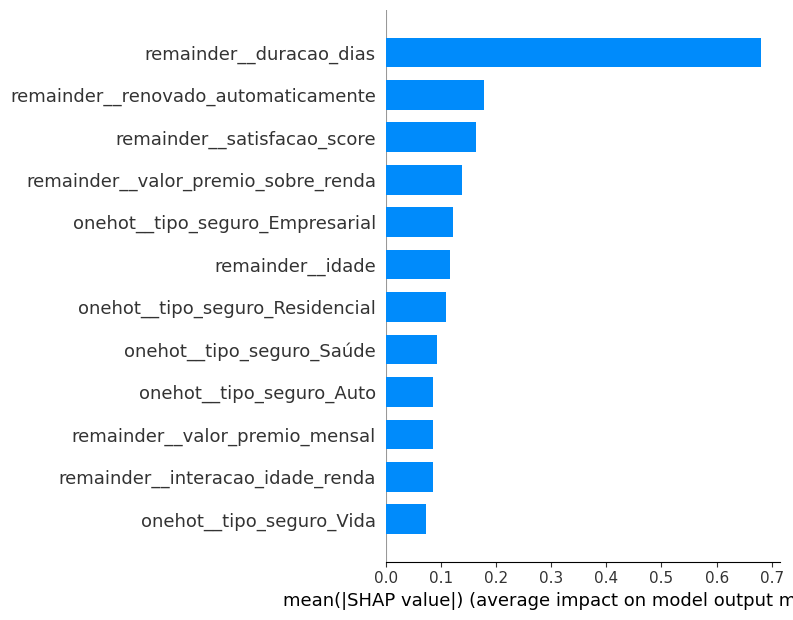


📝 Top 10 features que MAIS impactam a previsão:
                            feature  importance
            remainder__duracao_dias    0.680827
remainder__renovado_automaticamente    0.178352
        remainder__satisfacao_score    0.164610
remainder__valor_premio_sobre_renda    0.138271
    onehot__tipo_seguro_Empresarial    0.123016
                   remainder__idade    0.115958
    onehot__tipo_seguro_Residencial    0.109843
          onehot__tipo_seguro_Saúde    0.092558
           onehot__tipo_seguro_Auto    0.086724
     remainder__valor_premio_mensal    0.085880

📝 Top 10 features que MENOS impactam a previsão:
                            feature  importance
        remainder__satisfacao_score    0.164610
remainder__valor_premio_sobre_renda    0.138271
    onehot__tipo_seguro_Empresarial    0.123016
                   remainder__idade    0.115958
    onehot__tipo_seguro_Residencial    0.109843
          onehot__tipo_seguro_Saúde    0.092558
           onehot__tipo_seguro_Auto  

In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# 1. Dados
X = df_att_2.drop("cancelado", axis=1)
y = df_att_2["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["tipo_seguro"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop=None), categorical_features)],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X)

# 3. Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 5. Treina CatBoost
model = CatBoostClassifier(random_state=42, verbose=0, eval_metric='F1')
model.fit(X_train, y_train)

# 6. Avaliação
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔎 Métricas:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - CatBoost")
plt.legend()
plt.grid()
plt.show()

# 7. SHAP - Explicação com gráfico de barras
explainer = shap.TreeExplainer(model)

# Converte para array denso se for esparso
if hasattr(X_test, "toarray"):
    X_test_dense = X_test.toarray()
else:
    X_test_dense = X_test

shap_values = explainer.shap_values(X_test_dense)

shap.summary_plot(
    shap_values,
    X_test_dense,
    feature_names=encoder.get_feature_names_out(),
    plot_type="bar"
)# 1. Calcula importância média absoluta dos valores SHAP por feature
shap_importance = np.abs(shap_values).mean(axis=0)

# 2. Pega nomes das features
feature_names = encoder.get_feature_names_out()

# 3. Cria DataFrame para facilitar visualização
df_shap_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_importance
})

# 4. Ordena do mais importante para o menos importante
df_shap_imp_sorted = df_shap_imp.sort_values(by='importance', ascending=False)

print("\n📝 Top 10 features que MAIS impactam a previsão:")
print(df_shap_imp_sorted.head(10).to_string(index=False))

print("\n📝 Top 10 features que MENOS impactam a previsão:")
print(df_shap_imp_sorted.tail(10).to_string(index=False))


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.metrics import precision_recall_curve


# 1. DataFrame pronto
df = df_att_2.copy()  # seu df já preparado

# 2. Define X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 3. Features categóricas para OneHot
categorical_features = ["tipo_seguro"]

# 4. Codificação
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop=None, sparse_output=False), categorical_features)],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X)

# 5. Aplica SMOTE para balancear
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 6. Divide treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 7. Instancia o modelo CatBoost (usaremos para RFE)
cat_model = CatBoostClassifier(random_seed=42, verbose=0, eval_metric='F1')

# 8. RFE para selecionar top 10 features usando CatBoost como estimator
rfe = RFE(estimator=cat_model, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

# 9. Índices das features selecionadas
selected_indices = rfe.get_support(indices=True)

# 10. Seleciona colunas nos dados
X_train_rfe = X_train[:, selected_indices]
X_test_rfe = X_test[:, selected_indices]

# 11. Treina o modelo final com as features selecionadas
final_model = CatBoostClassifier(random_seed=42, verbose=0, eval_metric='F1')
final_model.fit(X_train_rfe, y_train)

# 12. Avaliação
y_pred = final_model.predict(X_test_rfe)
y_proba = final_model.predict_proba(X_test_rfe)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 13. Mapear nomes das features selecionadas para exibir
ohe_feature_names = encoder.named_transformers_["onehot"].get_feature_names_out(categorical_features)
remainder_features = [f for f in X.columns if f not in categorical_features]
all_feature_names = list(ohe_feature_names) + remainder_features

print("\nFeatures selecionadas pelo RFE com CatBoost:")
for idx in selected_indices:
    print(f" - {all_feature_names[idx]}")
    
explainer = shap.TreeExplainer(final_model)

# 2. Calcula valores SHAP para o conjunto de teste com features selecionadas
shap_values = explainer.shap_values(X_test_rfe)

# 3. Plota gráfico de barras (feature importance)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, features=X_test_rfe, feature_names=[all_feature_names[i] for i in selected_indices], plot_type='bar')

# 4. Resumo escrito das importâncias
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_importance = sorted(zip([all_feature_names[i] for i in selected_indices], mean_abs_shap), key=lambda x: x[1], reverse=True)

print("\n📝 Importância média das features pelo SHAP (top):")
for feat, val in feat_importance:
    print(f" - {feat}: {val:.4f}")
    
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="b")
plt.plot(thresholds, recalls[:-1], label="Recall", color="r")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall por Threshold")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

for t in [0.3, 0.4, 0.5, 0.6]:
    y_pred_t = (y_proba >= t).astype(int)
    p = precision_score(y_test, y_pred_t)
    r = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    print(f"\nThreshold = {t:.1f}")
    print(f"  Precision: {p:.4f}")
    print(f"  Recall:    {r:.4f}")
    print(f"  F1-score:  {f1:.4f}")

              precision    recall  f1-score   support

           0       0.67      0.77      0.71       722
           1       0.72      0.60      0.66       710

    accuracy                           0.69      1432
   macro avg       0.69      0.69      0.69      1432
weighted avg       0.69      0.69      0.69      1432

ROC AUC: 0.7370254769614919
Confusion Matrix:
 [[558 164]
 [281 429]]

Features selecionadas pelo RFE com CatBoost:
 - tipo_seguro_Auto
 - tipo_seguro_Residencial
 - tipo_seguro_Vida
 - idade
 - valor_premio_mensal
 - renovado_automaticamente
 - duracao_dias
 - satisfacao_score
 - valor_premio_sobre_renda
 - interacao_idade_renda


NameError: name 'shap' is not defined

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.metrics import precision_recall_curve


# 1. DataFrame pronto
df = df_att_2.copy()  # seu df já preparado

# 2. Define X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 3. Features categóricas para OneHot
categorical_features = ["tipo_seguro"]

# 4. Codificação
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop=None, sparse_output=False), categorical_features)],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X)

# 5. Aplica SMOTE para balancear
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 6. Divide treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 7. Instancia o modelo CatBoost (usaremos para RFE)
cat_model = CatBoostClassifier(random_seed=42, verbose=0, eval_metric='F1')

# 8. RFE para selecionar top 10 features usando CatBoost como estimator
rfe = RFE(estimator=cat_model, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

# 9. Índices das features selecionadas
selected_indices = rfe.get_support(indices=True)

# 10. Seleciona colunas nos dados
X_train_rfe = X_train[:, selected_indices]
X_test_rfe = X_test[:, selected_indices]

# 11. Treina o modelo final com as features selecionadas
final_model = CatBoostClassifier(random_seed=42, verbose=0, eval_metric='F1')
final_model.fit(X_train_rfe, y_train)

# 12. Avaliação
y_pred = final_model.predict(X_test_rfe)
y_proba = final_model.predict_proba(X_test_rfe)[:, 1]

# Aplica o threshold customizado
threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)

# Avaliação
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    

              precision    recall  f1-score   support

           0       0.68      0.60      0.64       722
           1       0.64      0.72      0.68       710

    accuracy                           0.66      1432
   macro avg       0.66      0.66      0.66      1432
weighted avg       0.66      0.66      0.66      1432

ROC AUC: 0.7370254769614919
Confusion Matrix:
 [[431 291]
 [200 510]]


# Aplicando o modelo em contratos ativos

In [12]:
query = """ 
SELECT
  substr(c.id_cliente, 2) AS id_cliente,
  cl.data_nascimento,
  CAST(strftime('%Y', 'now') AS INTEGER) - CAST(strftime('%Y', cl.data_nascimento) AS INTEGER) AS idade,
  cl.renda_mensal,
  c.tipo_seguro,
  c.valor_premio_mensal,
  c.satisfacao_ultima_avaliacao,
  c.renovado_automaticamente,
  DATE(c.data_inicio) AS inicio,
  DATE(c.data_fim) AS fim,
  julianday(c.data_fim) - julianday(c.data_inicio) AS duracao_dias

FROM contratos c
JOIN clientes cl ON c.id_cliente = cl.id_cliente

-- ❌ Exclui contratos cancelados
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato

-- ✅ Apenas contratos ativos (não cancelados e vigentes hoje)
WHERE ca.id_contrato IS NULL
  AND DATE('now') BETWEEN DATE(c.data_inicio) AND DATE(c.data_fim)
;
"""

df_ativos = pd.read_sql_query(query, conn)

df_ativos['id_cliente'] = df_ativos['id_cliente'].astype(int)
df_ativos = df_ativos.drop(columns=['data_nascimento', 'inicio', 'fim'])

In [13]:
df_at = df_ativos.copy()
mapa_satisfacao = {'Baixa': 0, 'Média': 1, 'Alta': 2}
df_at['satisfacao_score'] = df_at['satisfacao_ultima_avaliacao'].map(mapa_satisfacao)


df_at['valor_premio_sobre_renda'] = df_at['valor_premio_mensal'] / df_at['renda_mensal']
df_at['interacao_idade_renda'] = df_at['idade'] * df_at['renda_mensal']


df_at

,id_cliente,idade,renda_mensal,tipo_seguro,valor_premio_mensal,satisfacao_ultima_avaliacao,renovado_automaticamente,duracao_dias,satisfacao_score,valor_premio_sobre_renda,interacao_idade_renda
0,4599,67,18950.78,Vida,962.07,Baixa,0,730.0,0,0.050767,1269702.26
1,2429,77,13945.07,Saúde,1158.48,Baixa,1,730.0,0,0.083075,1073770.39
2,251,69,16550.97,Empresarial,326.96,Alta,1,730.0,2,0.019755,1142016.93
3,3339,31,13071.21,Auto,1473.87,Baixa,0,730.0,0,0.112757,405207.51
4,333,56,13616.06,Vida,759.35,Alta,1,180.0,2,0.055769,762499.36
...,...,...,...,...,...,...,...,...,...,...,...
3573,2154,25,19385.90,Vida,493.28,Baixa,0,365.0,0,0.025445,484647.50
3574,414,26,4328.09,Auto,1457.88,Alta,0,730.0,2,0.336841,112530.34
3575,1858,38,5072.22,Saúde,405.92,Baixa,1,730.0,0,0.080028,192744.36
3576,1410,45,1655.74,Vida,897.26,Alta,0,730.0,2,0.541909,74508.30


In [17]:
import pandas as pd

# 1. Copia do dataframe de contratos ativos
df_pred = df_at.copy()

# 2. Aplica mesma codificação OneHot
X_pred_encoded = encoder.transform(df_pred)

# 3. Seleciona as mesmas features escolhidas pelo RFE
X_pred_rfe = X_pred_encoded[:, selected_indices]

# 4. Prediz a probabilidade de cancelamento
y_pred_proba_ativos = final_model.predict_proba(X_pred_rfe)[:, 1]

# 5. Define threshold e aplica a classificação
threshold = 0.1
df_pred["prob_cancelamento"] = y_pred_proba_ativos
df_pred["tende_cancelar"] = (df_pred["prob_cancelamento"] >= threshold).astype(int)

# 6. Exibe os 10 contratos com maior risco de cancelamento
top_risco = df_pred.sort_values("prob_cancelamento", ascending=False).head(10)
print("🔍 Top 10 contratos ativos com maior risco de cancelamento:")
print(top_risco[["prob_cancelamento", "tende_cancelar"] + [col for col in df_pred.columns if col not in ["prob_cancelamento", "tende_cancelar"]][:3]])  # mostra 3 colunas extras

# 7. (Opcional) Exporta para CSV os clientes em risco
df_pred[df_pred["tende_cancelar"] == 1].to_csv("clientes_com_risco_cancelamento.csv", index=False)
clientes_risco_alto = df_pred[df_pred["prob_cancelamento"] > 0.5]
qtd_risco_alto = clientes_risco_alto.shape[0]
print(f"📊 Clientes com mais de 50% de chance de cancelar: {qtd_risco_alto}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔍 Top 10 contratos ativos com maior risco de cancelamento:
      prob_cancelamento  tende_cancelar  id_cliente  idade  renda_mensal
1677           0.895119               1        3045     70       1646.94
1034           0.878929               1        2161     69      17399.21
2896           0.863676               1        4239     53      17248.18
2866           0.841479               1        3697     80      13443.18
414            0.810479               1        3830     53      19453.09
3269           0.796074               1        2963     80       4279.07
1926           0.786964               1        3231     41       3349.86
2475           0.782947               1        1214     58      18036.52
3493           0.782200               1        1618     80       5771.86
804            0.782126               1        3410     23       9638.32
📊 Clientes com mais de 50% de chance de cancelar: 504
Confusion Matrix:
 [[431 291]
 [200 510]]


sss